In [1]:
from torch.utils.data import DataLoader, random_split,TensorDataset
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import NN_classes
from torchvision import datasets, transforms
import training_methods
import DataLoading
import pivottablejs
import math
%matplotlib inline
import seaborn as sns

In [2]:
#executions = ["Network_Line_Out_N_101_N_102_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_101_N_105_cac1","Network_Line_Out_N_102_N_104_cac1","Network_Line_Out_N_102_N_106_cac1","Network_Line_Out_N_103_N_109_cac1"]
#executions = ["Network_Line_Out_N_101_N_102_cac1"]
#executions = ["Network_Full_Generation_Full","Network_Line_In_N_101_N_102_cac1","Network_Line_In_N_101_N_103_cac1","Network_Line_In_N_101_N_105_cac1"]

executions = ["Network_Existing_Generation_Full"]

sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w",per = period,sc=sc)
executions = all_executions[1:10]
te_s = 0.1
val_s = 0.2

In [3]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
1227


In [4]:
ts_in,ts_out =  DataLoading.split_tr_val_te(dfs_in,dfs_out,executions,te_s,val_s)

In [5]:
d_ft_in, d_ft_out = DataLoading.concat_and_normalize(ts_in,ts_out,executions)

In [6]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

training_loader = DataLoader(train,batch_size=32)
validation_loader = DataLoader(train,batch_size=32)

In [7]:
def create_model(nb_hidden, input_size, dropout_ratio):
    hidden_sizes = []
    if nb_hidden == 0:
        hidden_sizes.append(input_size)
    elif nb_hidden == 1:
        hidden_sizes.extend([int(math.sqrt(input_size))])
    elif nb_hidden == 2:
        hidden_sizes.extend([int(math.sqrt(input_size)), int(math.sqrt(math.sqrt(input_size)))])
    elif nb_hidden == 3:
        hidden_sizes.extend([int(input_size / 4), int(input_size / 16), int(input_size / 64)])



    if nb_hidden == 0:
        model_class = NN_classes.ObjectiveEstimator_ANN_Single_layer
    elif nb_hidden == 1:
        model_class = NN_classes.ObjectiveEstimator_ANN_1hidden_layer
    elif nb_hidden == 2:
        model_class = NN_classes.ObjectiveEstimator_ANN_2hidden_layer
    elif nb_hidden == 3:
        model_class = NN_classes.ObjectiveEstimator_ANN_3hidden_layer
    model = model_class(input_size=input_size, hidden_sizes=hidden_sizes, output_size=1, dropout_ratio=dor)
    print(model,dor,nb_hidden)
    return model

In [10]:
learning_rates = [0.01*4**i for i in range(3)]
loss_fn = torch.nn.MSELoss()
nbs_e = [4,8,12]#,4,8]
i=0
nbs_hidden = [0,1,2,3]
dors = [0]#,0.1,0.2,0.4]
results = pd.DataFrame()
folder_to_save = "RTS24_AC_12w"
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            for dor in dors:
                m = create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor)
                if dor is None:
                    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr"
                else:                 
                    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
                optimizer = torch.optim.Adam(m.parameters(), lr=lr)
                train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,folder_to_save)

                saved_models = dict()

                for mt in ["min_val","all_epochs"]:
                    path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"


                    model = m
                    m.load_state_dict(torch.load(path))
                    m.eval()

                    test_predictions = m(d_ft_in["test"].float())
                    test_loss = loss_fn(test_predictions,d_ft_out["test"])

                    train_predictions = m(d_ft_in["train"].float())
                    train_loss = loss_fn(train_predictions,d_ft_out["train"])

                    validation_prediction = m(d_ft_in["val"].float())
                    validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                    if mt == "min_val": 
                        min_val = True
                    else: 
                        min_val = False

                    r = pd.DataFrame({"Model_type": nb_hidden,
                                      "Min_val":min_val,
                                      "Epochs": nb_e,
                                      "Lr":lr,
                                      "Dor": dor,
                                      "Tr_l":train_loss.item(),
                                      "Te_l":test_loss.item(),
                                      "V_l": validation_loss.item()}
                                     ,index = [i]
                    )
                    i+=1
                    results = pd.concat([results,r])

ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
) 0 0
EPOCH 1:
  batch 1 loss: 0.0001398173812776804
  batch 101 loss: 0.1586406407452523
  batch 201 loss: 0.00014118325937488409
  batch 301 loss: 8.096177173683828e-05
  batch 401 loss: 9.90935379536495e-05


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.035919564745541324 valid 0.00019866936781909317
EPOCH 2:
  batch 1 loss: 6.000007124384865e-07
  batch 101 loss: 3.7357704330815976e-05
  batch 201 loss: 5.330982817213226e-05
  batch 301 loss: 2.894053589898249e-05
  batch 401 loss: 8.906744471573802e-05
LOSS train 5.947155338625661e-05 valid 0.00016058000619523227
EPOCH 3:
  batch 1 loss: 2.6121218979824337e-07
  batch 101 loss: 3.930450857865253e-05
  batch 201 loss: 0.00010180937398445167
  batch 301 loss: 0.00023323037463796937
  batch 401 loss: 0.00015954672208863486
LOSS train 0.00013164083147102642 valid 0.00036362078390084207
EPOCH 4:
  batch 1 loss: 2.656290598679334e-06
  batch 101 loss: 0.00018224253232801857
  batch 201 loss: 6.99857623965272e-05
  batch 301 loss: 4.5193153365516995e-05
  batch 401 loss: 0.0001264547496043633
LOSS train 0.00019055059289864443 valid 0.012457850389182568


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1971])) that is different to the input size (torch.Size([1971, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([14148])) that is different to the input size (torch.Size([14148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3537])) that is different to the input size (torch.Size([3537, 1])). This will likely lead to incorrect results due to broadcastin

ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0 1
EPOCH 1:
  batch 1 loss: 8.913058787584305e-05
  batch 101 loss: 0.03511278539280283
  batch 201 loss: 5.5124865866673645e-05
  batch 301 loss: 3.598213260431748e-05
  batch 401 loss: 2.1471341743790616e-05
LOSS train 0.007972459852391306 valid 5.6656110245967284e-05
EPOCH 2:
  batch 1 loss: 1.4097095117904247e-07
  batch 101 loss: 4.177051236240459e-06
  batch 201 loss: 5.723134957236198e-06
  batch 301 loss: 6.433188012238134e-06
  batch 401 loss: 5.9980331582210055e-06
LOSS train 5.594165436293119e-06 valid 4.825448922929354e-05
EPOCH 3:
  batch 1 loss: 1.1961312793573598e-08
  batch 101 loss: 4.804748200228914e-06
  batch 201 loss: 4.293244986683931e-06
  batch 301 loss: 4.780525641763234e-06
  batch 401 loss: 4.653659205757776e-06
LOSS train 4.544848347232548e

  batch 101 loss: 8.945123964271039
  batch 201 loss: 2.6302503148087908e-05
  batch 301 loss: 2.19729291643489e-05
  batch 401 loss: 1.4866874900576477e-05
LOSS train 2.019280530516372 valid 4.188019738649018e-05
EPOCH 2:
  batch 1 loss: 3.688259539558203e-08
  batch 101 loss: 5.881314745295185e-06
  batch 201 loss: 4.411972436457745e-06
  batch 301 loss: 5.112290766930982e-06
  batch 401 loss: 4.789388825372498e-06
LOSS train 4.925854465453364e-06 valid 5.9439862525323406e-05
EPOCH 3:
  batch 1 loss: 4.6177342483133545e-08
  batch 101 loss: 4.965640918328517e-06
  batch 201 loss: 5.812016117943131e-06
  batch 301 loss: 6.838375041695599e-06
  batch 401 loss: 6.469398819461958e-06
LOSS train 5.9526129298491516e-06 valid 5.8650031860452145e-05
EPOCH 4:
  batch 1 loss: 2.3816466637072154e-07
  batch 101 loss: 1.1817582943365324e-05
  batch 201 loss: 1.0867928694437978e-05
  batch 301 loss: 1.3423143478803467e-05
  batch 401 loss: 7.122111482544824e-06
LOSS train 1.095074825596325e-05 va

  batch 401 loss: 0.0034162008258408604
LOSS train 0.002922235282826898 valid 0.0074731092900037766
EPOCH 8:
  batch 1 loss: 5.22959278896451e-05
  batch 101 loss: 0.003975816387392115
  batch 201 loss: 0.003946711393664373
  batch 301 loss: 0.0035537241381416607
  batch 401 loss: 0.002439428385368956
LOSS train 0.003298366599610909 valid 0.0013076363829895854
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0 1
EPOCH 1:
  batch 1 loss: 3.114022314548492e-05
  batch 101 loss: 0.06495047225108465
  batch 201 loss: 0.0020124564783736785
  batch 301 loss: 7.689639202908438e-05
  batch 401 loss: 8.671985319779197e-05
LOSS train 0.015167882382221224 valid 8.456564683001488e-05
EPOCH 2:
  batch 1 loss: 9.916511771734804e-07
  batch 101 loss: 9.368188086227746e-05
  batch 201 loss: 9.828956000546895e-05
  batch 301 loss: 0.

  batch 201 loss: 3.807152044828399e-05
  batch 301 loss: 0.00012364143941908878
  batch 401 loss: 0.0004570087195634187
LOSS train 0.00021965102837974868 valid 0.00048164138570427895
EPOCH 3:
  batch 1 loss: 2.5557380286045374e-06
  batch 101 loss: 0.00016554037119703935
  batch 201 loss: 5.744326876993e-05
  batch 301 loss: 0.00017930369380678713
  batch 401 loss: 0.001953342294909817
LOSS train 0.0005569338806288043 valid 0.0013259568950161338
EPOCH 4:
  batch 1 loss: 2.68813269212842e-05
  batch 101 loss: 0.0008317526069276937
  batch 201 loss: 0.00011950586862781165
  batch 301 loss: 0.00014718886840000777
  batch 401 loss: 0.0009810677595123707
LOSS train 0.0007059266131638577 valid 0.0007906716200523078
EPOCH 5:
  batch 1 loss: 1.2211976572871208e-05
  batch 101 loss: 0.01786712179375172
  batch 201 loss: 0.116812201179564
  batch 301 loss: 0.01172009497997351
  batch 401 loss: 0.1778469452614081
LOSS train 0.09010198907306827 valid 0.02989695593714714
EPOCH 6:
  batch 1 loss: 0

LOSS train 2.4868761934829188e-05 valid 7.626844308106229e-05
EPOCH 6:
  batch 1 loss: 6.696018681395799e-07
  batch 101 loss: 4.4201487815485054e-05
  batch 201 loss: 1.5485209585222036e-05
  batch 301 loss: 9.099422741201124e-06
  batch 401 loss: 1.0429019212097047e-05
LOSS train 1.9211765013746524e-05 valid 0.00010953203309327364
EPOCH 7:
  batch 1 loss: 2.934983785962686e-07
  batch 101 loss: 1.9398668691792408e-05
  batch 201 loss: 1.5760619649540786e-05
  batch 301 loss: 9.412846303007427e-06
  batch 401 loss: 1.8184269984971026e-05
LOSS train 1.5791652426207005e-05 valid 4.676835305872373e-05
EPOCH 8:
  batch 1 loss: 8.058316780079622e-08
  batch 101 loss: 2.7431195333633697e-05
  batch 201 loss: 1.2923038654548691e-05
  batch 301 loss: 1.0648817446536896e-05
  batch 401 loss: 1.574266384892553e-05
LOSS train 1.6467116820395286e-05 valid 0.00012130599498050287
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): 

  batch 101 loss: 85891.86369325181
  batch 201 loss: 0.5512992471456528
  batch 301 loss: 0.4684519079327583
  batch 401 loss: 0.38145128220319746
LOSS train 19389.02947625466 valid 0.30437031388282776
EPOCH 2:
  batch 1 loss: 0.002987316846847534
  batch 101 loss: 0.2657986703515053
  batch 201 loss: 0.19759531036019326
  batch 301 loss: 0.14170437887310983
  batch 401 loss: 0.0980952589213848
LOSS train 0.1664424307526638 valid 0.0672483891248703
EPOCH 3:
  batch 1 loss: 0.0006458085775375367
  batch 101 loss: 0.05438256781548262
  batch 201 loss: 0.03447965705767274
  batch 301 loss: 0.021048620389774442
  batch 401 loss: 0.012380391554906965
LOSS train 0.028548740300415064 valid 0.007239541504532099
EPOCH 4:
  batch 1 loss: 6.344644352793694e-05
  batch 101 loss: 0.00539127089548856
  batch 201 loss: 0.0028912643948569893
  batch 301 loss: 0.0014955052256118507
  batch 401 loss: 0.0007576201917254366
LOSS train 0.0024405609779916577 valid 0.0003966710064560175
EPOCH 5:
  batch 1 l

  batch 401 loss: 4.906824096735818e-05
LOSS train 4.730711033538411e-05 valid 6.600574124604464e-05
EPOCH 11:
  batch 1 loss: 5.330640851752833e-07
  batch 101 loss: 4.6832771537026475e-05
  batch 201 loss: 4.829083518472998e-05
  batch 301 loss: 4.900351536463177e-05
  batch 401 loss: 4.8650406863117724e-05
LOSS train 4.8222280970098655e-05 valid 6.155604205559939e-05
EPOCH 12:
  batch 1 loss: 2.6838795747607946e-07
  batch 101 loss: 4.4460508017181156e-05
  batch 201 loss: 4.5750511758626545e-05
  batch 301 loss: 4.538771353480797e-05
  batch 401 loss: 4.3960645975005264e-05
LOSS train 4.492041701207582e-05 valid 6.446228508139029e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0 2
EPOCH 1:
  batch 1 loss: 0.000415131039917469
  batch 101 los

  batch 201 loss: 9.637970977564691e-05
  batch 301 loss: 0.00012255521784368284
  batch 401 loss: 0.00010209320199578543
LOSS train 0.00010313126434302174 valid 0.0006259115762077272
EPOCH 3:
  batch 1 loss: 3.243551473133266e-06
  batch 101 loss: 0.00010875933905253988
  batch 201 loss: 7.600264835787129e-05
  batch 301 loss: 0.00017010434688700116
  batch 401 loss: 0.0012912975934068526
LOSS train 0.0004740850495964523 valid 0.0012272900203242898
EPOCH 4:
  batch 1 loss: 1.0843286290764808e-05
  batch 101 loss: 0.002008457598531095
  batch 201 loss: 0.0006309439550295792
  batch 301 loss: 0.0001574600755282063
  batch 401 loss: 8.99953977750556e-05
LOSS train 0.0006616636024395199 valid 0.00044425606029108167
EPOCH 5:
  batch 1 loss: 1.4560125418938696e-06
  batch 101 loss: 0.0021493020378397887
  batch 201 loss: 0.2889185733496561
  batch 301 loss: 0.03340547026862623
  batch 401 loss: 0.0025584542282376787
LOSS train 0.07404342714703716 valid 0.00866194162517786
EPOCH 6:
  batch 1

  batch 101 loss: 5.494172249882467e-06
  batch 201 loss: 5.155620009986706e-06
  batch 301 loss: 6.553394239006138e-06
  batch 401 loss: 6.475903609555189e-06
LOSS train 5.910139967556223e-06 valid 4.77788235002663e-05
EPOCH 8:
  batch 1 loss: 2.055725417449139e-08
  batch 101 loss: 5.058066015806162e-06
  batch 201 loss: 8.239438552095635e-06
  batch 301 loss: 8.973240646810154e-06
  batch 401 loss: 5.695125104239196e-06
LOSS train 7.123384385610024e-06 valid 5.507864261744544e-05
EPOCH 9:
  batch 1 loss: 4.607603386830306e-08
  batch 101 loss: 9.027460635593342e-06
  batch 201 loss: 1.511575421886846e-05
  batch 301 loss: 1.5114172830976713e-05
  batch 401 loss: 6.117890155223904e-06
LOSS train 1.175351694842886e-05 valid 4.6175875468179584e-05
EPOCH 10:
  batch 1 loss: 9.57798192757764e-09
  batch 101 loss: 1.5133134172629071e-05
  batch 201 loss: 1.2997901511653254e-05
  batch 301 loss: 9.795881831564657e-06
  batch 401 loss: 5.617684852836646e-06
LOSS train 1.04821626010702e-05 v

  batch 201 loss: 0.14576332101918524
  batch 301 loss: 0.9362481112417299
  batch 401 loss: 1.539442822923884
LOSS train 0.861587531193941 valid 0.5839481949806213
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0 1
EPOCH 1:
  batch 1 loss: 1.980020198971033e-05
  batch 101 loss: 72.59806510257926
  batch 201 loss: 0.006413718519506801
  batch 301 loss: 7.941078256408218e-05
  batch 401 loss: 7.209772654277913e-05
LOSS train 16.389318799362925 valid 6.459046562667936e-05
EPOCH 2:
  batch 1 loss: 4.815955617232249e-07
  batch 101 loss: 7.512435715852916e-05
  batch 201 loss: 7.710052531365364e-05
  batch 301 loss: 7.904448512817908e-05
  batch 401 loss: 8.184150081888219e-05
LOSS train 7.863427755197155e-05 valid 7.260815618792549e-05
EPOCH 3:
  batch 1 loss: 7.22504046279937e-07
  batch 101 loss: 8.51895705136485e-

LOSS train 0.004546416352659887 valid 0.00040020482265390456
EPOCH 4:
  batch 1 loss: 5.530298221856356e-06
  batch 101 loss: 0.0002814434876927407
  batch 201 loss: 0.00013764324290605146
  batch 301 loss: 8.699310115844128e-05
  batch 401 loss: 7.030992115687695e-05
LOSS train 0.00013784978118380276 valid 6.372108327923343e-05
EPOCH 5:
  batch 1 loss: 4.4543081457959487e-07
  batch 101 loss: 6.47212098010641e-05
  batch 201 loss: 6.358291280776029e-05
  batch 301 loss: 6.300536519120215e-05
  batch 401 loss: 6.328601513814646e-05
LOSS train 6.408073409404248e-05 valid 6.164169462863356e-05
EPOCH 6:
  batch 1 loss: 3.053294494748116e-07
  batch 101 loss: 6.328790079351165e-05
  batch 201 loss: 6.346885623315757e-05
  batch 301 loss: 6.332474093142082e-05
  batch 401 loss: 6.37891521819256e-05
LOSS train 6.39374443822205e-05 valid 6.166748062241822e-05
EPOCH 7:
  batch 1 loss: 3.097015360253863e-07
  batch 101 loss: 6.389355520695972e-05
  batch 201 loss: 6.410621837858343e-05
  batch 

In [ ]:
f = (results.Model_type == 1) &  (results.Min_val ==True) & (results.Epochs !=8)
results[f].boxplot(column = ["Te_l", "Tr_l","V_l"],by = ["Dor"],layout = (3,1),sharey = False)

In [ ]:
results.to_csv("Loss_results_csv/10_exec_Hyperparam")

<Axes: xlabel='Epochs', ylabel='Te_l'>

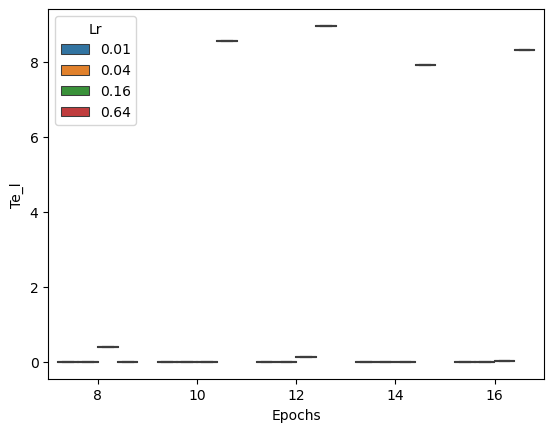

In [57]:
f = (results.Dor ==0) &(results.Model_type ==3)&(results.Epochs >=8)  #& (results.Min_val == True)  
sns.boxplot(x = "Epochs", y = "Te_l",data=results[f],hue = "Lr")

<Axes: xlabel='Epochs', ylabel='Te_l'>

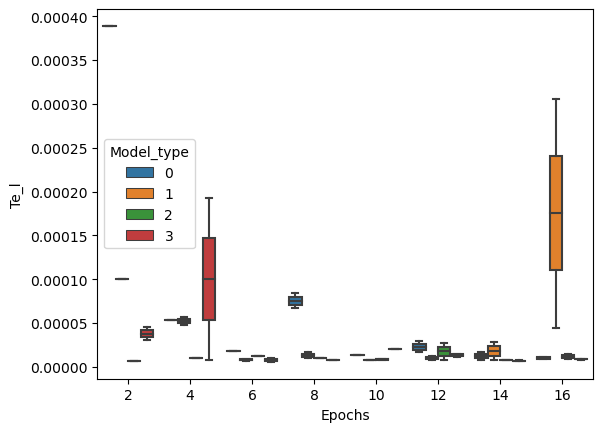

In [48]:
f = (results.Lr ==0.01)#(results.Dor ==0) #& (results.Min_val == True)  
sns.boxplot(x = "Epochs", y = "Te_l",data=results[f],hue = "Model_type")

## Old code 

In [ ]:
learning_rates = [0.01*4**i for i in range(3)]
loss_fn = torch.nn.MSELoss()
nbs_e = [2,4]#,4,8]
i=0
nbs_hidden = [0,1,2,3]
results = pd.DataFrame()
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            m = create_model(nb_hidden,input_size=d_ft_in['train'].shape[1])
            m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr"
            optimizer = torch.optim.Adam(m.parameters(), lr=lr)
            train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,True)
            
            saved_models = dict()
            
            for mt in ["min_val","all_epochs"]:
                path = f"trained_models/{mt}/model_{m_name}.pth"

                
                model = m
                m.load_state_dict(torch.load(path))
                m.eval()

                test_predictions = m(d_ft_in["test"].float())
                test_loss = loss_fn(test_predictions,d_ft_out["test"])
                
                train_predictions = m(d_ft_in["train"].float())
                train_loss = loss_fn(train_predictions,d_ft_out["train"])
                
                validation_prediction = m(d_ft_in["val"].float())
                validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                if mt == "min_val": 
                    min_val = True
                else: 
                    min_val = False

                r = pd.DataFrame({"Model_type": nb_hidden,"Min_val":min_val,"Epochs": nb_e,"Lr":lr, "Tr_l":train_loss.item(),"Te_l":test_loss.item(),"V_l": validation_loss.item()},index = [i]
                )
                i+=1
                results = pd.concat([results,r])